In [23]:
import tensorflow as tf
import tensorflow_hub as hub
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
import re
import unicodedata
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from tensorflow import keras
from tensorflow.keras.layers import Dense,Dropout, Input
from tqdm import tqdm
import pickle
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score, accuracy_score, classification_report
import matplotlib.pyplot as plt
import itertools
from sklearn.utils import shuffle
from tensorflow.keras import regularizers
from transformers import TFDistilBertModel, DistilBertTokenizer, DistilBertConfig,  DistilBertForSequenceClassification, TFDistilBertForSequenceClassification

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\jelme\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
# Functions to preprocess the data
# stopwords, shortwords and special characters are removed 
def unicode_to_ascii(s):
    return ''.join(c for c in unicodedata.normalize('NFD', s) if unicodedata.category(c) != 'Mn')

def clean_stopwords_shortwords(w):
    stopwords_list=stopwords.words('english')
    words = w.split() 
    clean_words = [word for word in words if (word not in stopwords_list) and len(word) > 2]
    return " ".join(clean_words) 

def preprocess_sentence(w):
    w = unicode_to_ascii(w.lower().strip())
    w = re.sub(r"([?.!,¿])", r" ", w)
    w = re.sub(r'[" "]+', " ", w)
    w = re.sub(r"[^a-zA-Z?.!,¿]+", " ", w)
    w = clean_stopwords_shortwords(w)
    w = re.sub(r'@\w+', '',w)
    return w

In [7]:
TRAIN_FILE_PATH = 'NLP_data/train.csv'
TEST_FILE_PATH = 'NLP_data/test.csv'

train_data = pd.read_csv(TRAIN_FILE_PATH)
test_data = pd.read_csv(TEST_FILE_PATH)

train_data['Title'] = train_data['Title'].map(preprocess_sentence)
train_data['Description'] = train_data['Description'].map(preprocess_sentence)

X_train = train_data['Title'] + " " + train_data['Description']
y_train = train_data['Class Index'].apply(lambda x: x-1).values # Classes need to begin from 0

test_data['Title'] = test_data['Title'].map(preprocess_sentence)
test_data['Description'] = test_data['Description'].map(preprocess_sentence)

X_test = test_data['Title'] + " " + test_data['Description']
y_test = test_data['Class Index'].apply(lambda x: x-1).values # Classes need to begin from 0

len(X_train),len(y_train)

(120000, 120000)

In [8]:
max_len = 32
num_classes = 4

# Tokenize Data

In [9]:
# Load tokinezer 
dbert_tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

In [10]:
# Tokenize training data
input_ids = []
attention_masks = []

for sent in X_train:
    dbert_inps=dbert_tokenizer.encode_plus(sent,add_special_tokens = True, max_length = max_len, padding = 'max_length', return_attention_mask = True, truncation=True)
    input_ids.append(dbert_inps['input_ids'])
    attention_masks.append(dbert_inps['attention_mask'])

train_input_ids = np.asarray(input_ids)
train_attention_masks = np.array(attention_masks)
y_train = np.array(y_train)

In [11]:
# Tokenize test data
test_input_ids = []
test_attention_masks = []

for sent in X_test:
    dbert_inps = dbert_tokenizer.encode_plus(sent, add_special_tokens = True, max_length = max_len, padding = 'max_length', return_attention_mask = True,truncation=True)
    test_input_ids.append(dbert_inps['input_ids'])
    test_attention_masks.append(dbert_inps['attention_mask'])

test_input_ids = np.asarray(test_input_ids)
test_attention_masks = np.array(test_attention_masks)
y_test = np.array(y_test)

# Optimize pretrained distilbert model

In [13]:
# Load pretrained distilbert model
dbert_model_pretrained = TFDistilBertModel.from_pretrained('distilbert-base-uncased') #num_labels = 4

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertModel: ['vocab_projector', 'vocab_transform', 'activation_13', 'vocab_layer_norm']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFDistilBertModel were initialized from the model checkpoint at distilbert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


In [14]:
# function to create keras model with distilbert model, to train and generate output
def create_model_pretrained():
    inps = Input(shape = (max_len,), dtype='int64')
    masks = Input(shape = (max_len,), dtype='int64')
    dbert_layer = dbert_model_pretrained(inps, attention_mask=masks)[0][:,0,:]
    pred = Dense(num_classes, activation='softmax',kernel_regularizer=regularizers.l2(0.01)) (dbert_layer)   #(dropout)
    model = tf.keras.Model(inputs=[inps,masks], outputs=pred)
    print(model.summary())
    return model

In [16]:
pretrained_model = create_model_pretrained()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32)]         0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 32)]         0           []                               
                                                                                                  
 tf_distil_bert_model_1 (TFDist  TFBaseModelOutput(l  66362880   ['input_1[0][0]',                
 ilBertModel)                   ast_hidden_state=(N               'input_2[0][0]']                
                                one, 32, 768),                                                    
                                 hidden_states=None                                           

In [17]:
train_inp = train_input_ids
train_label = y_train
train_mask = train_attention_masks

val_inp = test_input_ids
val_label = y_test
val_mask = test_attention_masks

print('Train inp shape {} Val input shape {}\nTrain label shape {} Val label shape {}\nTrain attention mask shape {} Val attention mask shape {}'.format(train_inp.shape,val_inp.shape,train_label.shape,val_label.shape,train_mask.shape,val_mask.shape))

log_dir='dbert_model_pretrained'
model_save_path='./dbert_model_pretrained.h5'

callbacks = [tf.keras.callbacks.ModelCheckpoint(filepath = model_save_path, save_weights_only=True, monitor='val_loss', mode='min', save_best_only=True),keras.callbacks.TensorBoard(log_dir=log_dir)]

loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
optimizer = tf.keras.optimizers.Adam(learning_rate=3e-5)

pretrained_model.compile(loss=loss, optimizer=optimizer, metrics=[metric])
history = pretrained_model.fit([train_inp,train_mask],train_label,batch_size=16,epochs=1,validation_data=([val_inp,val_mask],val_label),callbacks=callbacks)

Train inp shape (120000, 32) Val input shape (7600, 32)
Train label shape (120000,) Val label shape (7600,)
Train attention mask shape (120000, 32) Val attention mask shape (7600, 32)


KeyboardInterrupt: 

In [ ]:
# load weights from saved optimized pretrained model
optimized_pretrained_model = create_model_pretrained()
optimized_pretrained_model.compile(loss=loss,optimizer=optimizer, metrics=[metric])
optimized_pretrained_model.load_weights(model_save_path)


In [18]:
preds = optimized_pretrained_model.predict([val_inp, val_mask], batch_size=16)
pred_labels = np.argmax(preds, axis=1)
pred_labels


array([0, 2, 2, ..., 3, 3, 2], dtype=int64)

In [19]:
acc = accuracy_score(val_label, pred_labels)
acc

0.28460526315789475

In [22]:
target_names = ['world', 'sports', 'business', 'science']
print('Classification Report:')
print(classification_report(val_label,pred_labels,target_names=target_names)) 


Classification Report:
              precision    recall  f1-score   support

       world       0.22      0.31      0.25      1900
      sports       0.33      0.00      0.00      1900
    business       0.29      0.34      0.31      1900
     science       0.35      0.49      0.41      1900

    accuracy                           0.28      7600
   macro avg       0.30      0.28      0.24      7600
weighted avg       0.30      0.28      0.24      7600



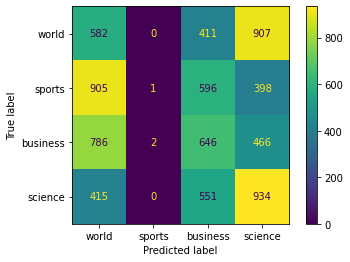

In [24]:
cm = confusion_matrix(val_label, pred_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_names)
disp.plot()
plt.show()


# Training from scratch


In [25]:
config = DistilBertConfig()
dbert_model_untrained = TFDistilBertModel(config)

In [26]:
# function to create keras model with distilbert model, to train and generate output
def create_model_untrained():
    inps = Input(shape = (max_len,), dtype='int64')
    masks = Input(shape = (max_len,), dtype='int64')
    dbert_layer = dbert_model_untrained(inps, attention_mask=masks)[0][:,0,:]
    pred = Dense(num_classes, activation='softmax',kernel_regularizer=regularizers.l2(0.01)) (dbert_layer)   #(dropout)
    model = tf.keras.Model(inputs=[inps,masks], outputs=pred)
    print(model.summary())
    return model

In [27]:
scratch_model = create_model_untrained()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 32)]         0           []                               
                                                                                                  
 input_4 (InputLayer)           [(None, 32)]         0           []                               
                                                                                                  
 tf_distil_bert_model_2 (TFDist  TFBaseModelOutput(l  66362880   ['input_3[0][0]',                
 ilBertModel)                   ast_hidden_state=(N               'input_4[0][0]']                
                                one, 32, 768),                                                    
                                 hidden_states=None                                         

In [ ]:
train_inp = train_input_ids
train_label = y_train
train_mask = train_attention_masks

val_inp = test_input_ids
val_label = y_test
val_mask = test_attention_masks

print('Train inp shape {} Val input shape {}\nTrain label shape {} Val label shape {}\nTrain attention mask shape {} Val attention mask shape {}'.format(train_inp.shape,val_inp.shape,train_label.shape,val_label.shape,train_mask.shape,val_mask.shape))

log_dir='dbert_model_scratch'
model_save_path='./dbert_model_scratch.h5'

callbacks = [tf.keras.callbacks.ModelCheckpoint(filepath = model_save_path, save_weights_only=True, monitor='val_loss', mode='min', save_best_only=True),keras.callbacks.TensorBoard(log_dir=log_dir)]

loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
optimizer = tf.keras.optimizers.Adam(learning_rate=3e-5)

scratch_model.compile(loss=loss, optimizer=optimizer, metrics=[metric])
scratch_model_model.fit([train_inp,train_mask],train_label,batch_size=16,epochs=1,validation_data=([val_inp,val_mask],val_label),callbacks=callbacks)

In [ ]:
# load weights from saved trained model from scratch
scratch_trained_model = create_model_untrained()
scratch_trained_model.compile(loss=loss,optimizer=optimizer, metrics=[metric])
scratch_trained_model.load_weights(model_save_path)

In [ ]:
preds_scratch = scratch_trained_model.predict([val_inp, val_mask], batch_size=16)
pred_labels_scratch = np.argmax(preds, axis=1)
pred_labels_scratch

In [ ]:
acc_scratch = accuracy_score(val_label, pred_labels_scratch)
acc_scratch

In [ ]:
target_names = ['world', 'sports', 'business', 'science']
print('Classification Report:')
print(classification_report(val_label,pred_labels_scratch,target_names=target_names)) 

In [ ]:
cm_scratch = confusion_matrix(val_label, pred_labels_scratch)
disp_scratch = ConfusionMatrixDisplay(confusion_matrix=cm_scratch, display_labels=target_names)
disp_scratch.plot()
plt.show()